# Importing Libraries

In [21]:
import pandas as pd 
import numpy as np 
import plotly.express as px
import numpy as np
from geopy.distance import geodesic
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer,SimpleImputer

## Problem Statement 

Link for dataset on kaggle: https://www.kaggle.com/datasets/ithikashr/delivery-time-estimationanalysis?select=DeliveryTimeTaken.csv

Dataset: Delivery Time Taken
Dataset Descrition:
- Sourced from kaggle
- Data has around 45593 records
- Features: There are 11 input features including delivery person demographics (Age, Ratings), logistical factors (Road traffic density, Distance category, Hour), and external conditions (Festival, City)
- Target Variable: Time_taken, representing the total delivery time in minutes.


Type of problem: Regression

Primary Evaluation metric: MAE
- Gives absolute error in minutes 
- Less sensitive to outlier



In [22]:
df = pd.read_csv('/Users/dhruvbhatt/Desktop/Personal Projects/AI/BITS-AI-ML/Assignment_MLP/Data/DeliveryTimeTaken.csv')

# Exploratory Data Analysis

In [23]:
df.isna().sum()

ID                                0
Delivery_person_ID                0
Delivery_person_Age            1854
Delivery_person_Ratings        1908
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weather                           0
Road_traffic_density            601
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries             993
Festival                        228
City                           1200
Time_taken                        0
dtype: int64

In [24]:
df.shape

(45593, 20)

# Analysis on Target Variable

<Axes: xlabel='Time_taken', ylabel='Count'>

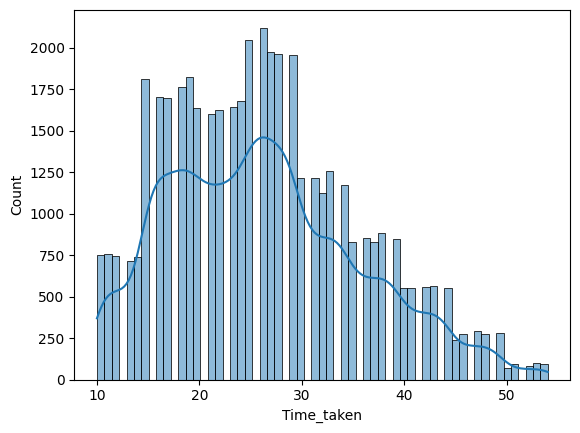

In [25]:
import seaborn as sns
sns.histplot(df['Time_taken'],kde=True)
# target is right skewed 

# Feature Analysis

In [26]:
df.columns

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weather', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken'],
      dtype='object')

In [27]:
df['Weather'].unique()

array(['conditions'], dtype=object)

In [28]:
# we can remove functions like ID and delivery person ID
# Making useful feature of distance between locations as feature and dropping location features with distance as metric
# We can remove time_picked_up feature, since we are estimating delivery time from time_orderd, so we can't estimate time it would be pickedup
# We can also remove feature weather since it's has only one constant value that would not help model

df.drop(columns = ['ID', 'Delivery_person_ID','Weather','Time_Order_picked'],inplace=True)
df['Distance_km'] = df.apply(lambda df: geodesic((df['Restaurant_latitude'],df['Restaurant_longitude']),
                                                    (df['Delivery_location_latitude'],df['Delivery_location_longitude'])).km,axis=1)
                    

### Distance Column analysis

In [29]:
pd.cut(df['Distance_km'],bins=[0,10,20,30,np.inf]).value_counts()

Distance_km
(0.0, 10.0]     24350
(10.0, 20.0]    18692
(20.0, 30.0]     2120
(30.0, inf]       431
Name: count, dtype: int64

(array([ 70., 131.,  68.,   0.,   0.,   0.,   0.,   0., 141.,  21.]),
 array([ 2203.91829976,  3954.4840241 ,  5705.04974844,  7455.61547278,
         9206.18119712, 10956.74692146, 12707.3126458 , 14457.87837014,
        16208.44409448, 17959.00981882, 19709.57554316]),
 <BarContainer object of 10 artists>)

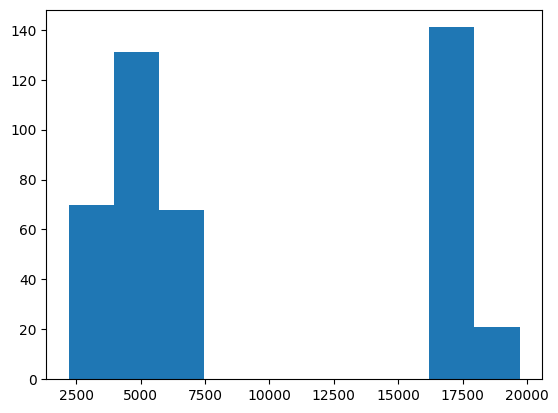

In [30]:
plt.hist(df[df['Distance_km']>30]['Distance_km'])

In [31]:
# Records with distance>30km contain records with location data issue, removing these records
df = df[df['Distance_km']<30].copy()

### Delivery person age

<Axes: xlabel='Delivery_person_Age', ylabel='Count'>

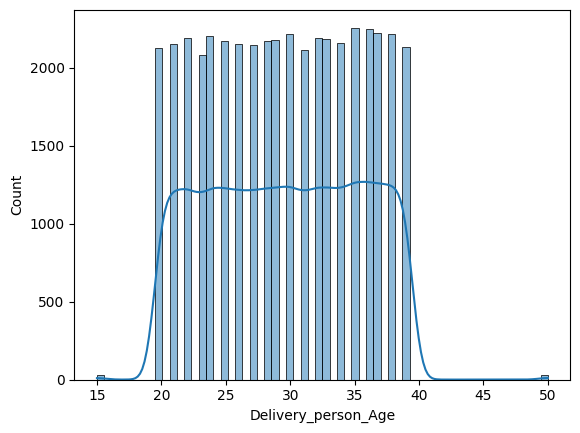

In [ ]:
sns.histplot(df['Delivery_person_Age'],kde=True)

In [35]:
# Using SimpleImputer for Delivery person age: Delivery person age follows a uniform distribution, no assumption that missing data is somewhat related

### Delivery person ratings

In [36]:
df['Delivery_person_Ratings']=np.clip(df['Delivery_person_Ratings'],0,5)

<Axes: xlabel='Delivery_person_Ratings', ylabel='Density'>

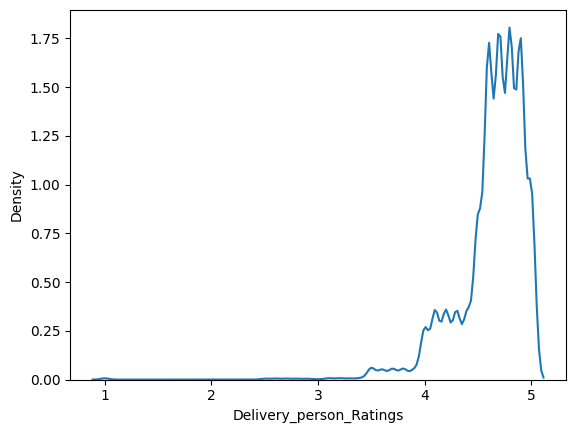

In [37]:
sns.kdeplot(df['Delivery_person_Ratings'])

- median for Delivery person rating:ratings are skewed, we would need a number thats representative, we can't derive ratings from other feature so using median
- Dropping nulls for feature such as TimeOrderd, Festival, City, road_traffic_density
- Using mode for multiple_deliveries

In [38]:
df.columns

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Road_traffic_density', 'Vehicle_condition', 'Type_of_order',
       'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City',
       'Time_taken', 'Distance_km'],
      dtype='object')

In [39]:
df.dropna(subset =['Time_Orderd','Festival', 'City','Road_traffic_density'] ,inplace=True)




In [40]:
df.drop(columns= [ 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude'],inplace=True)
# Dropping these since No requirement for modelling


In [41]:
# DateTime features
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Order_day'] = df['Order_Date'].dt.weekday
df['Order_Hour'] = df['Time_Orderd'].str.split(':').str[0]

df.drop(columns=['Order_Date', 'Time_Orderd'],inplace=True)


/var/folders/nx/8d3mtcp52nv15mptrctq96mh0000gn/T/ipykernel_10694/1292555293.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Order_Date'] = pd.to_datetime(df['Order_Date'])


# Analysing cat cols effect on time-taken


In [42]:
print(df.groupby(by=['Type_of_order'])['Time_taken'].mean())
print(df.groupby(by=['Type_of_order'])['Time_taken'].median())
# hence the distribution has similar mean median, Dropping this columns

Type_of_order
Buffet    26.479565
Drinks    26.395956
Meal      26.610726
Snack     26.445473
Name: Time_taken, dtype: float64
Type_of_order
Buffet    26.0
Drinks    26.0
Meal      26.0
Snack     26.0
Name: Time_taken, dtype: float64


In [43]:
df.drop(columns=['Type_of_order'],inplace=True)

In [44]:
print(df.groupby(by=['Road_traffic_density'])['Time_taken'].mean())
print(df.groupby(by=['Road_traffic_density'])['Time_taken'].median())

Road_traffic_density
High      27.337545
Jam       31.334276
Low       21.434822
Medium    26.851709
Name: Time_taken, dtype: float64
Road_traffic_density
High      27.0
Jam       31.0
Low       21.0
Medium    27.0
Name: Time_taken, dtype: float64


In [45]:
df.columns

Index(['Delivery_person_Age', 'Delivery_person_Ratings',
       'Road_traffic_density', 'Vehicle_condition', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken', 'Distance_km',
       'Order_day', 'Order_Hour'],
      dtype='object')

In [46]:
print(df.groupby(by=['Type_of_vehicle'])['Time_taken'].mean())
print(df.groupby(by=['Type_of_vehicle'])['Time_taken'].median())

# Electric scooter and scooter have similar central tendency

Type_of_vehicle
electric_scooter    24.561604
motorcycle          27.773970
scooter             24.677342
Name: Time_taken, dtype: float64
Type_of_vehicle
electric_scooter    24.0
motorcycle          27.0
scooter             24.0
Name: Time_taken, dtype: float64


### Multiple Deliveries

In [47]:
df.groupby('multiple_deliveries')['Time_taken'].agg(['mean','std'])

,mean,std
multiple_deliveries,,
0.0,23.121835,8.740865
1.0,26.991123,8.503096
2.0,40.459989,4.899235
3.0,47.843195,3.496794


# Train Test Splitting

In [48]:
df.head()

,Delivery_person_Age,Delivery_person_Ratings,Road_traffic_density,Vehicle_condition,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken,Distance_km,Order_day,Order_Hour
0,37.0,4.9,High,2,motorcycle,0.0,No,Urban,24.0,3.020737,5,11
1,34.0,4.5,Jam,2,scooter,1.0,No,Metropolitian,33.0,20.143737,4,19
2,23.0,4.4,Low,0,motorcycle,1.0,No,Urban,26.0,1.549693,5,8
3,38.0,4.7,Medium,0,motorcycle,1.0,No,Metropolitian,21.0,7.774497,1,17
4,32.0,4.6,High,1,scooter,1.0,No,Metropolitian,30.0,6.197898,5,13


In [49]:
df.isna().sum()

Delivery_person_Age        205
Delivery_person_Ratings    252
Road_traffic_density         0
Vehicle_condition            0
Type_of_vehicle              0
multiple_deliveries        899
Festival                     0
City                         0
Time_taken                   0
Distance_km                  0
Order_day                    0
Order_Hour                   0
dtype: int64

In [50]:
df_train,df_test = train_test_split(df,test_size = 0.3, random_state=42)

In [51]:
# Extracting numerical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Extracting categorical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Display results
print(f"Numerical Columns ({len(num_cols)}): {num_cols}")
print(f"Categorical Columns ({len(cat_cols)}): {cat_cols}")

Numerical Columns (6): ['Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition', 'multiple_deliveries', 'Time_taken', 'Distance_km']
Categorical Columns (5): ['Road_traffic_density', 'Type_of_vehicle', 'Festival', 'City', 'Order_Hour']


In [52]:
# Using imputer, onehotencoder and ordinal encoder train fitting and then apply same on test
num_cols = ['Delivery_person_Age', 'Delivery_person_Ratings','Distance_km']
cat_cols = ['Festival', 'City','Type_of_vehicle']
ord_cols = ['Road_traffic_density', 'Order_Hour','Vehicle_condition','multiple_deliveries']

def get_preprocessing_pipeline(num_cols, cat_ohe_cols, ord_cols, ord_mapping=None):
    """
    1. Imputes specific subsets of numeric/categorical columns.
    2. Applies Scaling and Encoding.
    """
    

    # 2. Pipeline for Numeric Columns (Median Imputation + Scaling)
    num_median_pipeline = Pipeline([
        ('impute_knn', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler())
    ])
    
    # 3. Pipeline for Categorical Columns (Mode Imputation + OneHot)
    cat_ohe_pipeline = Pipeline([
        ('impute_mode', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # 4. Pipeline for Ordinal Columns (Mode Imputation + Ordinal)
    # Note: If mapping is provided, you'd use a custom mapper, otherwise standard OrdinalEncoder
    cat_ord_pipeline = Pipeline([
        ('impute_mode', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder()) 
    ])

    # Combine everything into a ColumnTransformer
    preprocessor = ColumnTransformer(transformers=[
        ('num_median', num_median_pipeline, num_cols),
        ('cat_ohe', cat_ohe_pipeline, cat_ohe_cols),
        ('cat_ord', cat_ord_pipeline, ord_cols)
    ], remainder='drop') # 'drop' ensures only selected features reach the model

    return preprocessor
preprocessor = get_preprocessing_pipeline(num_cols,cat_cols,ord_cols)

In [53]:
X_train,y_train = df_train.drop(columns=['Time_taken']),df_train['Time_taken'].values.reshape(-1,1)
X_test,y_test = df_test.drop(columns=['Time_taken']),df_test['Time_taken'].values.reshape(-1,1)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Linear Regression and MLP Modelling


In [56]:
class LinearRegression:
    def __init__(self, lr, epoch, random_state=None):
        self.lr = lr
        self.epoch = epoch
        self.random_state = random_state
        self.weight = {}
        self.loss_history = [] 

    def fit(self, X, y):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        n_samples = X.shape[0]
        n_features = X.shape[1]
        
        self.weight['W'] = np.random.randn(n_features, 1) * 0.01 
        self.weight['B'] = 0.0
        
        y = y.reshape(-1, 1)

        for epoch in range(self.epoch):
            W, B = self.weight['W'], self.weight['B']
            
            y_hat = np.dot(X, W) + B 
            
            current_loss = np.mean(np.square(y_hat - y))
            self.loss_history.append(current_loss)
            
            error = y_hat - y
            dj_dw = (2 / n_samples) * np.dot(X.T, error)
            dj_db = (2 / n_samples) * np.sum(error)
            
            self.weight['W'] = W - self.lr * dj_dw
            self.weight['B'] = B - self.lr * dj_db
            
            # if epoch % 50 == 0:
        print(f'Final Loss: {current_loss}')
        return self

    def predict(self, X):
        return np.dot(X, self.weight['W']) + self.weight['B']
            

class MLP:
    def __init__(self, layerdims, learning_rate, random_state=None):
        self.layerdims = layerdims
        self.learning_rate = learning_rate
        self.random_state = random_state # Store the seed
        
    def initialize_parameter(self, X):
        # Set the seed here for reproducibility
        if self.random_state is not None:
            np.random.seed(self.random_state)
            
        self.weight = {}
        current_neuron = X.shape[1]
        
        for i, layer in enumerate(self.layerdims):
            std = np.sqrt(2.0 / current_neuron) 
            
            if i == len(self.layerdims) - 1:
                # Use 'W_final' for the last layer as per your logic
                self.weight['W_final'] = np.random.randn(current_neuron, layer) * std
                self.weight['B_final'] = np.zeros((1, layer))
            else:
                self.weight[f'W_{i+1}'] = np.random.randn(current_neuron, layer) * std
                self.weight[f'B_{i+1}'] = np.zeros((1, layer))

            current_neuron = layer
        print(f'Initialized Parameters with seed {self.random_state}')
    def forward_propogation(self,X_batch,grad_update=True):
        ''' We assume shape of X is (row,column) '''
        if grad_update:
            self.cache = {}
        A = X_batch
        layers= len(self.layerdims)
        if grad_update:
            self.cache['A_0'] = X_batch
        for layer in range(layers-1):
            W = self.weight[f'W_{layer+1}']
            B = self.weight[f'B_{layer+1}']
            Z = np.dot(A, W) + B
            A = RELU(Z) 
            if grad_update:
                self.cache[f'Z_{layer+1}'] = Z
                self.cache[f'A_{layer+1}'] = A
        
        A = np.dot(A,self.weight[f'W_final']) + self.weight[f'B_final']
        if grad_update:
            self.cache[f'A_final'] = A
        return np.vstack(A)
    def backward_propogation(self,y,y_hat,cache):
        n = len(y)
        final_layer= len(self.layerdims) #2
        grads = {}

        dj_dy =  (2/n) * (y_hat - y) #(m,1)

        dj_dw_final = np.dot(cache[f'A_{final_layer-1}'].T,dj_dy) #A_1 (m,t) *(m,1) == t,1
        dj_db_final = np.sum(dj_dy, axis=0, keepdims=True) ## m,1 == 1,1

        grads['dj_dw_final'] = dj_dw_final 
        grads['dj_db_final'] = dj_db_final
        current_grad = dj_dy
        for layer in reversed(range(1,final_layer)):
            Z = cache[f'Z_{layer}'] # m,t 
            # W = self.weight[f'W_{layer}'] # W1 = n,t
            A = cache[f'A_{layer-1}'] # m,n
            if layer+1==len(self.layerdims):
                W_next = self.weight[f'W_final']
            else:
                W_next = self.weight[f'W_{layer+1}']

            dj_da = np.dot(current_grad,W_next.T) # m,1 X 1,t==m,t
            dj_dz = dj_da*(Z>0) # m,t

            dj_dw = np.dot(A.T,dj_dz)  # n,m x m,t == n,t
            dj_db = np.sum(dj_dz, axis=0, keepdims=True)  # m,t sum accross row (1,m)

            grads[f'dj_dw_{layer}'] = dj_dw
            grads[f'dj_db_{layer}'] = dj_db
            current_grad = dj_dz
        self.grads = grads
        return grads
    def update_weights(self):
        for layer in range(1,len(self.layerdims)+1):
            if layer != len(self.layerdims):
                W,b = self.weight[f'W_{layer}'],self.weight[f'B_{layer}']
                dj_dw, dj_db = self.grads[f'dj_dw_{layer}'], self.grads[f'dj_db_{layer}']
                lr = self.learning_rate
                assert dj_dw.shape == W.shape,"Shape error"
                assert dj_db.shape == b.shape,"Shape error"
                W = W - lr*dj_dw
                b = b - lr*dj_db
                self.weight[f'W_{layer}'],self.weight[f'B_{layer}'] = W,b
            else:
                W,b = self.weight[f'W_final'],self.weight[f'B_final']
                dj_dw, dj_db = self.grads[f'dj_dw_final'], self.grads[f'dj_db_final']
                assert dj_dw.shape == W.shape,"Shape error"
                assert dj_db.shape == b.shape,"Shape error dj_db shape"
                
                lr = self.learning_rate
                W = W - lr*dj_dw
                b = b - lr*dj_db
                self.weight[f'W_final'],self.weight[f'B_final'] = W,b
    
    def fit(self, X, y, epochs, batch_size, validation):

        self.initialize_parameter(X)

        loss = []
        val_loss = []

        X_valid, y_valid = validation
        y_valid = y_valid.reshape(-1, 1)

        n_samples = X.shape[0]
        y = y.reshape(-1, 1)

        for epoch in range(epochs):

            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start in range(0, n_samples, batch_size):
                end = start + batch_size

                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                outputs = self.forward_propogation(X_batch)
                self.backward_propogation(y_batch, outputs, self.cache)
                self.update_weights()

            train_outputs = self.forward_propogation(X)
            train_loss = MSEloss(y, train_outputs.reshape(-1, 1))

            val_outputs = self.predict(X_valid)
            v_loss = MSEloss(y_valid, val_outputs.reshape(-1, 1))

            loss.append(train_loss)
            val_loss.append(v_loss)

            if epoch % 100 == 0:
                print(f"Epoch {epoch} | Train Loss: {train_loss:.5f} | Val Loss: {v_loss:.5f}")

        epochs_range = np.arange(len(loss))

        fig = px.line(
            x=epochs_range,
            y=loss,
            labels={'x': 'Epoch', 'y': 'Loss'},
            title='Training vs Validation Loss'
        )

        fig.add_scatter(
            x=epochs_range,
            y=val_loss,
            mode='lines',
            name='Validation Loss'
        )

        fig.update_traces(name='Training Loss', selector=dict(mode='lines'))
        fig.write_html("/Users/dhruvbhatt/Desktop/Personal Projects/AI/BITS-AI-ML/Assignment_MLP/Plots/training_validation_loss.html")
        fig.show()

        history = {'Loss':loss, 'Loss on Validation':val_loss}

        return history
    def predict(self,X_batch):
        return self.forward_propogation(X_batch,grad_update=False)

def RELU(X):
    return np.maximum(0, X)
def MSEloss(Y, Y_hat):
    loss = np.sum(np.square(Y-Y_hat))/len(Y_hat)
    return loss
def MAEloss(Y,Y_hat):
    loss = np.sum(np.abs(Y-Y_hat))/len(Y_hat)
    return loss
def MAPEloss(Y, Y_hat):
    mask = Y != 0
    return np.mean(np.abs((Y[mask] - Y_hat[mask]) / Y[mask])) * 100

In [57]:
import time
start = time.time()

baseline_model = LinearRegression(0.009,2000,42)
baseline_model.fit(X_train_processed,y_train)


end = time.time()
base_time = f"{end-start} sec"

Final Loss: 46.58319458390091


In [58]:
start = time.time()

mlp_model = MLP([50,30,20,1],0.00004,42)
mlp_model.fit(X_train_processed,y_train,epochs=2000,validation=(X_test_processed,y_test),batch_size=32)
end = time.time()
mlp_time = f"{end-start} sec"

Initialized Parameters with seed 42
Epoch 0 | Train Loss: 61.78635 | Val Loss: 60.64189
Epoch 100 | Train Loss: 32.74587 | Val Loss: 33.06392
Epoch 200 | Train Loss: 31.30552 | Val Loss: 31.79668
Epoch 300 | Train Loss: 30.36706 | Val Loss: 31.00595
Epoch 400 | Train Loss: 30.01992 | Val Loss: 30.78515
Epoch 500 | Train Loss: 28.99935 | Val Loss: 29.72308
Epoch 600 | Train Loss: 28.79812 | Val Loss: 29.58917
Epoch 700 | Train Loss: 28.81785 | Val Loss: 29.61116
Epoch 800 | Train Loss: 28.28728 | Val Loss: 29.28198
Epoch 900 | Train Loss: 28.23152 | Val Loss: 29.38482
Epoch 1000 | Train Loss: 28.28224 | Val Loss: 29.52877
Epoch 1100 | Train Loss: 27.98725 | Val Loss: 29.32442
Epoch 1200 | Train Loss: 29.86790 | Val Loss: 30.97133
Epoch 1300 | Train Loss: 27.71866 | Val Loss: 29.04298
Epoch 1400 | Train Loss: 28.72667 | Val Loss: 30.31169
Epoch 1500 | Train Loss: 27.84723 | Val Loss: 29.46189
Epoch 1600 | Train Loss: 27.59826 | Val Loss: 29.22797
Epoch 1700 | Train Loss: 27.55138 | Val L

# Assignment Summary

In [59]:
def get_assignment_results():
    results = {
        "dataset_name": "Delivery Time Taken Dataset",
        "n_samples": X_train_processed.shape[0],
        "n_features": X_train_processed.shape[1],
        "problem_type": "Regression",
        "primary_metric": "MAE",
        "baseline_model_metrics": {
            "test_performance": MAEloss(y_test, baseline_model.predict(X_test_processed)),
            "MAPE": MAPEloss(y_test, baseline_model.predict(X_test_processed)),
            "training_time": base_time
        },
        "mlp_model_metrics": {
            "architecture": mlp_model.layerdims,
            "test_performance": MAEloss(y_test, mlp_model.predict(X_test_processed)),
            "MAPE": MAPEloss(y_test, mlp_model.predict(X_test_processed)),
            "training_time": mlp_time
        }
    }
    return results


In [60]:

assignment_summary = get_assignment_results()
assignment_summary

{'dataset_name': 'Delivery Time Taken Dataset',
 'n_samples': 29654,
 'n_features': 15,
 'problem_type': 'Regression',
 'primary_metric': 'MAE',
 'baseline_model_metrics': {'test_performance': np.float64(5.387853386048021),
  'MAPE': np.float64(23.33964949749385),
  'training_time': '0.2529280185699463 sec'},
 'mlp_model_metrics': {'architecture': [50, 30, 20, 1],
  'test_performance': np.float64(4.2699756049151185),
  'MAPE': np.float64(18.190256215787418),
  'training_time': '165.63551998138428 sec'}}

# Model Analysis
- Using identical preprocessing and feature engineering, the baseline linear regression achieved an MAE of 5.4 minutes and MAPE of 23.34%, whereas the MLP reduced MAE to 4.27 minutes and MAPE to 18.2%. This corresponds to a 21% reduction in MAE, indicating that the MLP successfully captured non-linear relationships that the linear model could not represent.

- However, this performance gain came at a significant computational cost. The linear model trained in under one second, whereas the MLP required approximately 166 seconds. While a one-minute reduction in prediction error may be meaningful in high-volume or time-sensitive logistics scenarios, the trade-off between computational cost and predictive improvement must be evaluated depending on deployment constraints.

- As dataset size increases, the MLP may benefit from improved generalization due to its higher representational capacity, whereas the linear model may continue to underfit complex patterns. However, the MLP also introduces additional hyperparameter sensitivity and tuning complexity.

